```
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# Boosting Machine for Quantile Regression Example

## Goal 

The goal of this notebook is to illustrate how Snap ML's Boosting Machine can perform Quantile Regression and create prediction intervals.

This learning task will create a 90% prediction interval on the output of a single feature dataset, where the output represents a function f of the input.

## Source

The script is inspired by this example in sklearn:
https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html


## Code


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from snapml import BoostingMachineRegressor as SnapBoostingMachineRegressor
import matplotlib.pyplot as plt

/home/test/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/test/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/test/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/test/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecat

Generate some data for a synthetic regression problem by applying a
function f to a linear range of inputs.

In [2]:
def f(x):
    """The function to predict."""
    return  x * np.sin(x)

In [3]:
num_samples = 10000
X = np.atleast_2d(np.linspace(0, 20, num_samples)).T
expected_y = f(X).ravel()

Add random noise

In [4]:
mu, sigma = 0, 1.8
noise = np.random.default_rng().normal(mu, sigma, num_samples)
y = expected_y + noise

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

X_test_sorted = np.array(sorted(X_test))

Plot the true function f along with the target observations.

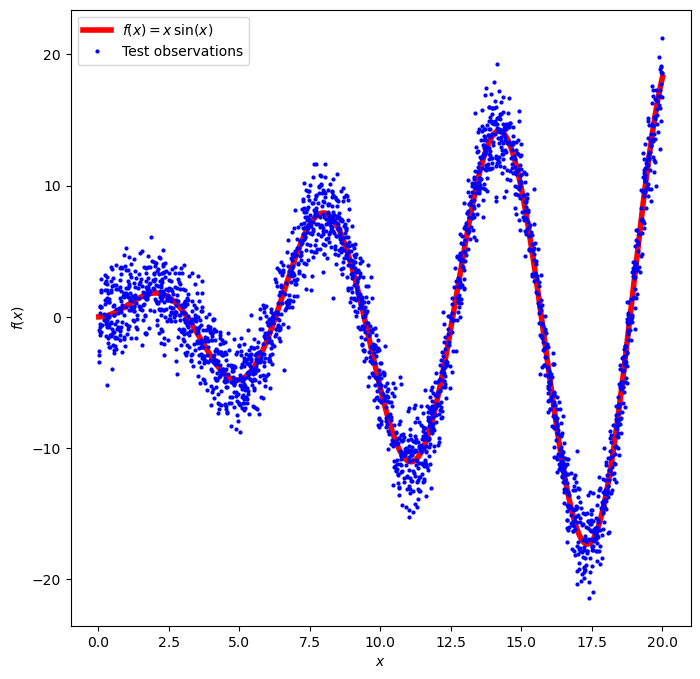

In [6]:
fig = plt.figure(figsize=(8, 8))
plt.plot(X_test_sorted, f(X_test_sorted), "r", linewidth=4, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=4, label="Test observations")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(loc="upper left")
plt.show()

We will fit SnapML Gradient Boosting models trained with the quantile loss and alpha=0.05, 0.5, 0.95.

The models obtained for alpha=0.05 and alpha=0.95 produce a 90% prediction interval (95% - 5% = 90%).

The model trained with alpha=0.5 produces a regression of the median: on average, there should be the same number of target observations above and below the predicted values.

We will use the following parameters for the optimization in all cases:

In [7]:
NUM_ROUND = 200
LEARNING_RATE = 0.1
MAX_DEPTH = 8
LAMBDA_2 = 2.0
HIST = False

common_params_snap = dict(
    learning_rate=LEARNING_RATE,
    num_round=NUM_ROUND,
    max_depth=MAX_DEPTH,
    lambda_l2 = LAMBDA_2,
    use_histograms = HIST,
    hist_nbins = 256,
)

In [8]:
all_models = {}
for alpha in [0.05, 0.5, 0.95]:
     gbr_s = SnapBoostingMachineRegressor(objective="quantile", alpha=alpha, **common_params_snap)
     all_models["q %1.2f" % alpha] = gbr_s.fit(X_train, y_train)

We will use the fitted SnapML Gradient Boosting models to predict the median (alpha=0.5) and get the 90% prediction interval (alpha=0.05 and alpha=0.95).

In [9]:
y_lower = all_models["q 0.05"].predict(X_test_sorted)
y_upper = all_models["q 0.95"].predict(X_test_sorted)
y_med = all_models["q 0.50"].predict(X_test_sorted)

We will estimate the performance of the SnapML models by comparing the predicted quantiles with the theoretical ones.

Plot the target observations, the theoretical median and the theoretical 90% interval (from 5th to 95th percentiles).

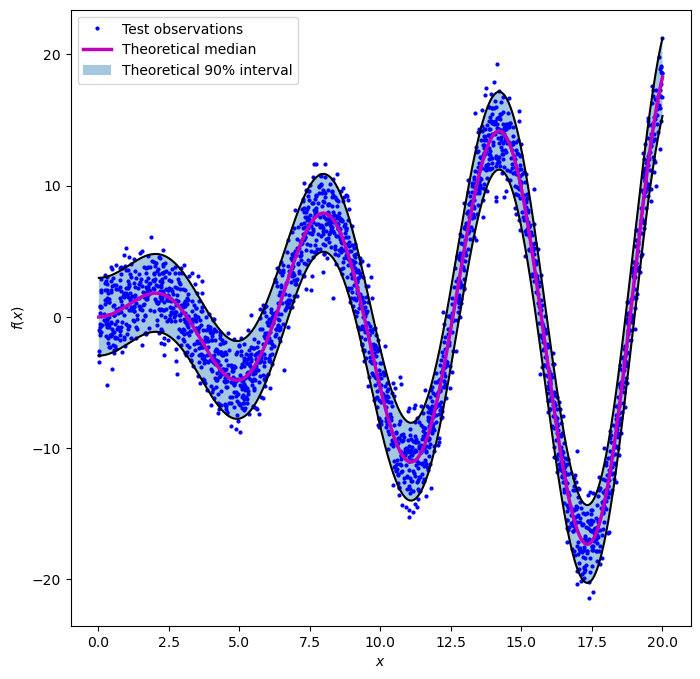

In [10]:
ty_upper = (f(X_test_sorted) + np.quantile(noise,0.95)).reshape(X_test.shape[0],)
ty_lower = (f(X_test_sorted) + np.quantile(noise,0.05)).reshape(X_test.shape[0],)
fig = plt.figure(figsize=(8, 8))
plt.plot(X_test, y_test, "b.", markersize=4, label="Test observations")
plt.plot(X_test_sorted, f(X_test_sorted) + np.quantile(noise,0.5), "m-", linewidth = 2.5, label="Theoretical median")
plt.plot(X_test_sorted, f(X_test_sorted) + np.quantile(noise,0.95), "k-")
plt.plot(X_test_sorted, f(X_test_sorted) + np.quantile(noise,0.05), "k-")
plt.fill_between(
    X_test_sorted.ravel(), ty_lower, ty_upper, alpha=0.4, label="Theoretical 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(loc="upper left")
plt.show()

Plot the target observations, the predictions of the median and the predicted 90% interval (from 5th to 95th  percentiles).

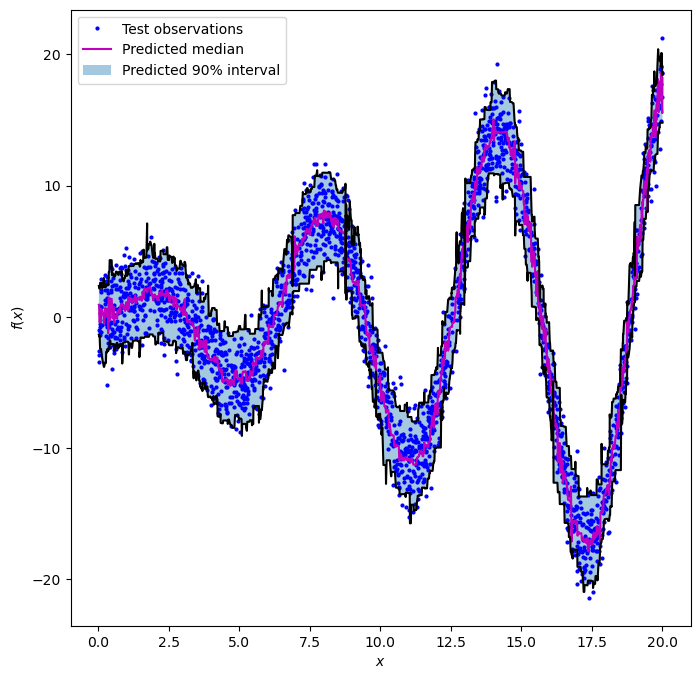

In [11]:
fig = plt.figure(figsize=(8, 8))
plt.plot(X_test, y_test, "b.", markersize=4, label="Test observations")
plt.plot(X_test_sorted, y_med, "m-", label="Predicted median")
plt.plot(X_test_sorted, y_upper, "k-")
plt.plot(X_test_sorted, y_lower, "k-")
plt.fill_between(
    X_test_sorted.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(loc="upper left")
plt.show()

Plot the theoretical and the predicted 90% interval (from 5th to 95th percentiles).

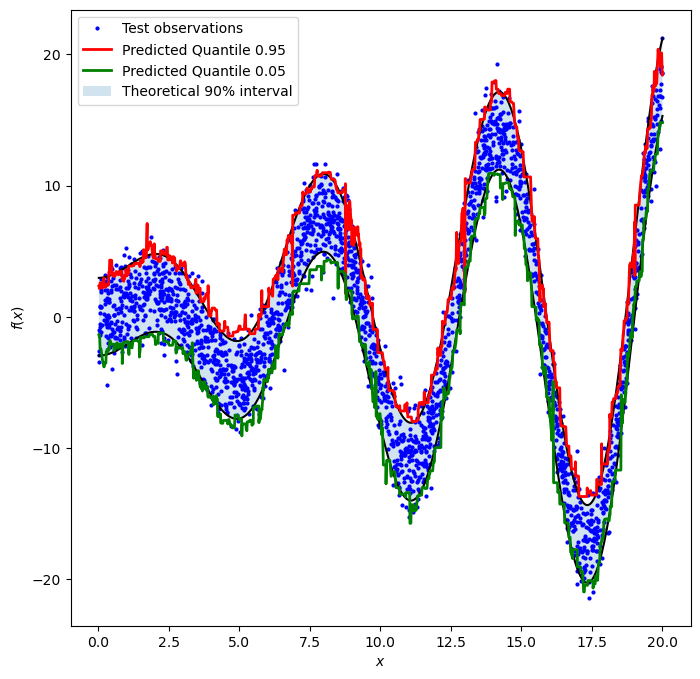

In [12]:
fig = plt.figure(figsize=(8, 8))
plt.plot(X_test, y_test, "b.", markersize=4, label="Test observations")
plt.plot(X_test_sorted, f(X_test_sorted) + np.quantile(noise,0.95), "k-")
plt.plot(X_test_sorted, f(X_test_sorted) + np.quantile(noise,0.05), "k-")
plt.plot(X_test_sorted, y_upper, "r-", linewidth = 2, label="Predicted Quantile 0.95")
plt.plot(X_test_sorted, y_lower, "g-", linewidth = 2, label="Predicted Quantile 0.05")
plt.fill_between(
    X_test_sorted.ravel(), ty_lower, ty_upper, alpha=0.2, label="Theoretical 90% interval"
)

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(loc="upper left")
plt.show()

## Disclaimer

Performance results always depend on the hardware and software environment. 
